In [ ]:
!pip install git+https://github.com/davidbau/baukit datasets bitsandbytes nnsight --upgrade

  Cloning https://github.com/davidbau/baukit to /tmp/pip-req-build-ycc2bk13
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /tmp/pip-req-build-ycc2bk13
  Resolved https://github.com/davidbau/baukit to commit 9d51abd51ebf29769aecc38c4cbef459b731a36e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, baukit
from baukit import TraceDict
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
import torch

class LLM(torch.nn.Module):
    """
    A module to capture hidden states during iterative generation and obtain per-layer output text.

    This class provides:
      - generate_layer_by_layer: Performs token-by-token generation while capturing the hidden states from each layer.
      - generate_text_by_layer  : Projects each layer's hidden states using LLaMA-style tied embeddings to recover output text.
                                   Also returns the overall final generated text (which should match a call to model.generate).
    """
    def __init__(self, layer_num, quant):
        super().__init__()
        self.layer_num = layer_num
        self.cuda_id = "0"
        self.quant = quant
        self.layer_names = []
        for i in range(self.layer_num):
            # Construct the layer name string; adjust if your model's architecture is different.
            self.layer_names.append(f'model.layers.{i}.post_attention_layernorm')

    def generate_layer_by_layer(self, model, tok, prefix, max_new_tokens=50, device="cuda:0"):
        """
        Iteratively generates text token-by-token while capturing the hidden state for the new token
        at each specified layer using TraceDict.

        Returns:
          hidden_states_dict: A dict mapping each layer name to a tensor of shape
                              (batch, generated_tokens, hidden_size) holding hidden states.
          generated_text   : A list of decoded text strings (one per batch sample) from the final output.
        """
        device = f"cuda:{self.cuda_id}"
        model = model.to(device)
        model.eval()

        # Tokenize the prompt
        inputs = tok(prefix, return_tensors="pt")
        if self.quant == 32:
            inputs = {k: v.to(device) for k, v in inputs.items()}
        generated = inputs["input_ids"]  # shape: (batch, seq_length)

        # Prepare dictionary to collect hidden states for each layer.
        hidden_states_dict = {ln: [] for ln in self.layer_names}

        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Use TraceDict to capture intermediate activations
                with TraceDict(model, self.layer_names) as tr:
                    outputs = model(input_ids=generated)
                    logits = outputs['logits']

                # For each tracked layer, extract the hidden state corresponding to the newly generated token.
                for ln in self.layer_names:
                    hs = tr[ln].output[0]
                    if hs.ndim == 2:
                        # When output is (seq_length, hidden_size)
                        token_hs = hs[-1, :].unsqueeze(0)  # (1, hidden_size)
                    elif hs.ndim == 3:
                        # When output is (batch, seq_length, hidden_size)
                        token_hs = hs[:, -1, :]            # (batch, hidden_size)
                    else:
                        raise RuntimeError(f"Unexpected dims for layer {ln}: {hs.ndim}")
                    hidden_states_dict[ln].append(token_hs)

                # Determine next token from the logits of the final layer output
                next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
                generated = torch.cat((generated, next_token), dim=1)

                # Stop if EOS token is generated (assumes batch size of 1)
                if next_token.item() == tok.eos_token_id:
                    break

        # Stack the list of hidden states so that each becomes (batch, generated_tokens, hidden_size)
        for ln in self.layer_names:
            hidden_states_dict[ln] = torch.stack(hidden_states_dict[ln], dim=1)

        generated_text = tok.batch_decode(generated, skip_special_tokens=True)
        return hidden_states_dict, generated_text

    def generate_text_by_layer(self, model, tok, prefix, max_new_tokens=50, device="cuda:0"):
        """
        Generates text iteratively while capturing hidden states from each layer, then projects these hidden states
        into vocabulary logits using LLaMA-style tied embeddings (found at model.model.embed_tokens.weight) and decodes
        them into text. The returned dictionary contains, for each layer number, the output text obtained via that
        layer's hidden states. In addition, the dictionary includes the final overall generated text under the key 'final',
        which should match the text output from model.generate.

        Returns:
          layer_text_dict: Dictionary in which each key is a layer number (or name) and each value is the decoded text.
                           The special key 'final' holds the overall generated text.
        """
        # Get the hidden states and overall generated text from iterative generation.
        hidden_states_dict, generated_text = self.generate_layer_by_layer(model, tok, prefix, max_new_tokens, device)
        layer_text_dict = {}

        # Loop over each layer and project hidden states to vocabulary logits.
        for layer_name in self.layer_names:
            hs_tensor = hidden_states_dict[layer_name]  # shape: (batch, tokens_generated, hidden_size)
            # Assume batch size of 1.
            hs_layer = hs_tensor[0]  # shape: (tokens_generated, hidden_size)

            # For LLaMA, the tied embeddings are typically at model.model.embed_tokens.weight.
            # Project hidden states to logits: (tokens_generated, vocab_size)
            logits = hs_layer @ model.model.embed_tokens.weight.T
            # For every generation step, choose the token with the highest logit.
            predicted_ids = torch.argmax(logits, dim=-1).tolist()
            # Decode the predicted tokens.
            text = tok.decode(predicted_ids, skip_special_tokens=True)

            # Extract layer number from the layer_name string.
            try:
                layer_num = int(layer_name.split('.')[2])
            except Exception:
                layer_num = layer_name
            layer_text_dict[layer_num] = text

        # Also add the overall final generated text (which should match model.generate's output)
        # generated_text is a list (with one entry for each batch sample). We assume batch=1.
        layer_text_dict["final"] = generated_text[0]

        return layer_text_dict

In [ ]:
import pandas as pd
import json
from datasets import load_dataset

class DataProcessing():

    def __init__(self, data_name, noise):
        self.data_name = data_name
        self.noise = noise

    """
        Select the way to get p and n samples given the dataset.
    """
    def dispacher(self):
        cot = None
        if self.data_name == 'StrategyQA':
            p, q = self.StrategyQA()
            prompt = 'Judge the question is true or false?'  + '\n' \
                'Q: Will Queen Elizabeth be buried in the Pantheon?' + '\n' \
                "Let us think step by step. The stem of the sentence is Queen Elizabeth, burial, pantheon. Inference: First, the Pantheon is a church, so it is possible that she could be buried there. Second, Queen Elizabeth II is still alive, so she has not been buried yet. Third, even if she were to be buried in the Pantheon, it is unlikely that we would know about it ahead of time, so it is hard to say for sure." + '\n' \
                'pred_ans: no'
            cot = 'Let us think step by step...'


        elif self.data_name == 'HallData':
            p, q = self.HallData()
            prompt = """Examine the question below. If the answer given is correct, respond with 'YES'. If not, respond with 'NO'.
            """
            cot = 'Let us think step by step...'

        elif self.data_name == 'HallDataV2':
            p, q = self.HallDataV2()
            prompt = """Examine the question below. If the answer given is correct, respond with 'YES'. If not, respond with 'NO'.
            """
            cot = 'Let us think step by step...'

        return p, q, prompt, cot



    """
        return the context that we enter to LLM.
    """
    def get_prompt(self, prompt, cot, question):
        if self.data_name in ['HallData', 'HallDataV2']:
            new_prompt = prompt + question + " " + cot

        return new_prompt

    def HallData(self):
        dataset = load_dataset("gagan3012/HallData")

        list1 = []
        list2 = []
        for i,t in zip(dataset['train']['prompt'],dataset['train']['label']):
            if t==True:
                list1.append(i)
            if t==False:
                list2.append(i)

        return list1, list2

    def HallDataV2(self):
        dataset = load_dataset("gagan3012/HallDataV2")

        list1 = []
        list2 = []
        for i,t in zip(dataset['train']['prompt'],dataset['train']['label']):
            if t==True:
                list1.append(i)
            if t==False:
                list2.append(i)

        return list1, list2



In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, baukit
from baukit import TraceDict
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

"""
    Adding noise to the questions.
    Input:
        question - the question needs to add noise.
    Return:
        noised_question - the question after adding noise.
    should have only aaa/bbb
"""
import numpy as np
def add_noise(question):
    # Adding three letters after the period.
    noise = np.random.choice(a=2) + 97
    noise = [chr(noise)] * 3
    noised_question = ''.join(noise) + question
    return noised_question

class LLM(torch.nn.Module):

    """
        Given a total layer, we construct a layer name list.
    """
    def __init__(self, cuda_id, layer_num, quant):
        self.layer_num = layer_num
        self.cuda_id = cuda_id
        self.layer_names = []
        self.quant = quant
        for i in range(self.layer_num):
            self.layer_names.append(f'model.layers.{i}.post_attention_layernorm')

    def get_hidden_states(self, model, tok, prefix):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if self.quant == 32:
            inp = {k: torch.tensor(v)[None].to(device) for k, v in tok(prefix).items()}
            model = model.to(device)
            with TraceDict(model, self.layer_names) as tr:
                logits = model(**inp)['logits']
            return torch.stack(
                [tr[ln].output[0][None, :] if ln == "transformer.wte" else tr[ln].output[0] for ln in self.layer_names])
        else:
            inp = {k: torch.tensor(v)[None].to(device) for k, v in tok(prefix).items()}
            with TraceDict(model, self.layer_names) as tr:
                logits = model(**inp)['logits']
            return torch.stack(
                [tr[ln].output[0][None, :] if ln == "transformer.wte" else tr[ln].output[0] for ln in self.layer_names])


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from tqdm import tqdm
import json

def run_model(model_name="Qwen/Qwen2.5-0.5B-Instruct",quant=32, dataset="dates", noise=0.1, cuda=0, clf="RF"):

    model_path="/path/to/cache_dir",
    if quant != 32:
        if quant == 8:
            quantization_config1 = BitsAndBytesConfig(load_in_8bit=True)
        elif quant == 16:
            # You can add specific torch_dtype or other options if needed for 16-bit quantization.
            pass
        else:
            raise ValueError("We don't have this quantization bit! Please try 8, 16, or 32.")

    # -----------------------------
    # Load Tokenizer and Model
    # -----------------------------
    cache_dir = model_path
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if quant == 32:
        model = AutoModelForCausalLM.from_pretrained(model_name)
    elif quant == 8:
        model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config1)
    elif quant == 16:
        model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
    else:
        raise ValueError("We don't have this quantization bit! Please try 8, 16, or 32.")

    # print(model.named_parameters())
    # for name, para in model.named_parameters():
    #     print(name, para)

    file_path = "/content/random_date_question_answer_dataset.csv"  # File path constant (if needed)

    # -----------------------------
    # Determine total layers for the model
    # -----------------------------
    model_2_layer = {
        "Qwen/Qwen2.5-0.5B-Instruct": 24,
        "Qwen/Qwen2.5-1.5B-Instruct": 24,
        "Qwen/Qwen2.5-3B-Instruct": 24,
        "Qwen/Qwen2.5-7B-Instruct": 24,
    }
    tot_layer = model.config.num_hidden_layers

    # -----------------------------
    # Data Processing Setup
    # -----------------------------
    # DataProcessing and LLM are assumed to be defined elsewhere.
    DP = DataProcessing(data_name=dataset, noise=noise)

    # The prompts are different among the datasets!
    p_question, n_question, prompt, cot = DP.dispacher()

    Model = LLM(cuda_id=cuda, layer_num=tot_layer, quant=quant)

    print("Model is training ...")
    list_acc = []
    list_f1 = []
    list_auc = []

    rp_logs = [[] for _ in range(tot_layer)]
    rp_questions = [[] for _ in range(tot_layer)]
    rp_log_data_list = []
    rp_question_data_list = []

    # -----------------------------
    # Process positive (p_question) examples
    # -----------------------------
    for q in tqdm(p_question):
        input_text = DP.get_prompt(prompt, cot, q)
        with torch.no_grad():
            # Get input_ids (not used further in the snippet but kept for consistency)
            messages = [
                {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
                {"role": "user", "content": input_text}
            ]
            input_text_new = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            input_ids = tokenizer(input_text, return_tensors="pt").input_ids
            hs = Model.get_hidden_states(model, tokenizer, input_text)
        for i in range(tot_layer):
            hs_i = hs[i, :, :]
            # Get the last token’s hidden states
            hs_i = hs_i[-1, :].cpu()
            try:
                hs_i = hs_i.numpy()
            except Exception:
                hs_i = hs_i.float().numpy()
            rp_logs[i].append(hs_i)

    # -----------------------------
    # Process negative (n_question) examples
    # -----------------------------
    for q in tqdm(n_question):
        input_text = DP.get_prompt(prompt, cot, q)
        with torch.no_grad():
            messages = [
                {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
                {"role": "user", "content": input_text}
            ]
            input_text_new = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            input_ids = tokenizer(input_text, return_tensors="pt").input_ids
            hs = Model.get_hidden_states(model, tokenizer, input_text)
        for i in range(tot_layer):
            hs_i = hs[i, :, :]
            hs_i = hs_i[-1, :].cpu()
            try:
                hs_i = hs_i.numpy()
            except Exception:
                hs_i = hs_i.float().numpy()
            rp_questions[i].append(hs_i)

    del model, tokenizer
    torch.cuda.empty_cache()

    # -----------------------------
    # Prepare data for evaluation
    # -----------------------------
    for i in range(tot_layer):
        rp_log_data_list.append(np.array(rp_logs[i]))
        rp_question_data_list.append(np.array(rp_questions[i]))

    labels_log = np.zeros(len(rp_log_data_list[0]))
    labels_question = np.ones(len(rp_question_data_list[0]))

    print("Evaluating ...")
    for i in range(tot_layer):
        rp_log_data_i = rp_log_data_list[i]
        rp_question_data_i = rp_question_data_list[i]

        X = np.concatenate((rp_log_data_i, rp_question_data_i), axis=0)
        y = np.concatenate((labels_log, labels_question), axis=0)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

        # Initialize the classifier based on the set variable 'clf'
        if clf == 'LR':
            classifier = LogisticRegression(penalty='l2')
        elif clf == 'RF':
            classifier = RandomForestClassifier(random_state=42)
        else:
            raise ImportError("The provided classifier is not recognized. Use 'LR' or 'RF'.")

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print("------------------------------------")
        print("This is layer", i)
        print(f'Accuracy: {accuracy}')

        f1 = f1_score(y_test, y_pred, average='binary')
        print(f'F1 Score: {f1}')

        # For ROC AUC, we need predicted probabilities
        y_prob = classifier.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f'ROC AUC Score: {roc_auc}')

        list_acc.append(accuracy)
        list_f1.append(f1)
        list_auc.append(roc_auc)

    # -----------------------------
    # Save evaluation results
    # -----------------------------
    dict_res = {"Acc": list_acc, "F1": list_f1, "AUC": list_auc}

    def LoadDataset(filename):
        with open(filename, 'r+') as f:
            read_dict = f.read()
        return json.loads(read_dict)

    def SaveDataset(filename, dataset):
        dict_json = json.dumps(dataset)
        with open(filename, 'w+') as f:
            f.write(dict_json)


    save_path_final = model_name.replace("/","_") + "_final.json"
    SaveDataset(save_path_final, dict_res)
    print(list_acc)
    print(list_f1)
    print(list_auc)

    return list_acc, list_f1, list_auc

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_accuracy_curves(acc_results, model_names, target_accuracy=0.80,
                         save_path="accuracy_layers.pdf"):
    """
    Render accuracy-vs-layer curves with target-crossing markers,
    formatted for an EMNLP paper (Times fonts, 3.3×2.2-inch canvas, 300 dpi).

    Parameters
    ----------
    acc_results : List[List[float]]
        Per-layer accuracies for each model.
    model_names : List[str]
        Human-readable model names.
    target_accuracy : float, optional
        Threshold to highlight (default 0.80).
    save_path : str or None, optional
        Path to save the figure; if None, the figure is only shown.
    """
    # --- Global style tweaks (Times & color-blind palette) ------------------
    sns.set_theme(context="paper", style="whitegrid", font_scale=1.3,
                  rc={"grid.linestyle": "--", "grid.alpha": 0.4,
                      "lines.markersize": 6,
                      "pdf.fonttype": 42,  # embed fonts cleanly
                      "ps.fonttype": 42})
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]

    palette = sns.color_palette("colorblind", n_colors=len(acc_results))
    fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi=300)  # two-column width

    # --- Plot each model -----------------------------------------------------
    for i, acc in enumerate(acc_results):
        acc = np.asarray(acc)
        x_vals = np.linspace(0, 100, num=len(acc))

        # Clean up label text
        label = (model_names[i]
                 .replace("-Instruct", "")
                 .replace("Qwen/", "")
                 .replace("Qwen2.5-", ""))

        # Main curve
        ln, = ax.plot(x_vals, acc, lw=1.5, marker="o",
                      mec=palette[i], color=palette[i],
                      label=label)

        # Where does the curve first cross the target?
        idx = np.argmax(acc >= target_accuracy)
        if acc[idx] >= target_accuracy:          # crossed at least once
            x_t = x_vals[idx]
            ax.axvline(x_t, ls=":", lw=1.2, color=palette[i])
            # Small numeric annotation right under the target line
            ax.annotate(f"{x_t:.0f}%", xy=(x_t, target_accuracy),
                        xytext=(0, -12), textcoords="offset points",
                        ha="center", va="top", fontsize=7)

    # --- Axes, legend, save --------------------------------------------------
    ax.set(xlabel="Layer progression (%)",
           ylabel="Accuracy",
           xlim=(0, 100), ylim=(0, 1.0),
           xticks=[0, 25, 50, 75, 100])
    ax.legend(frameon=False, loc="lower right", fontsize=8)

    fig.tight_layout(pad=0.05)
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", format="pdf")

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

def plot_accuracy_curves(acc_results, model_names,
                         target_accuracy=0.80,
                         dataset_name="dates",
                         save_path="accuracy_layers.pdf"):
    """EMNLP-style accuracy-vs-layer figure with uniform-colour TCP lines."""
    # --- global style -------------------------------------------------------
    sns.set_theme(context="paper", style="whitegrid", font_scale=1.1,
                  rc={"grid.linestyle": "--", "grid.alpha": 0.35,
                      "pdf.fonttype": 42, "ps.fonttype": 42})

    tcp_color = "black"                       # << change if you prefer
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300,
                           constrained_layout=True)
    palette = sns.color_palette("colorblind", n_colors=len(acc_results))
    # --- curves & TCP lines -------------------------------------------------
    for i, acc in enumerate(acc_results):
        acc = np.asarray(acc)
        x_vals = np.linspace(0, 100, len(acc))

        label = (model_names[i]
                 .replace("-Instruct", "")
                 .replace("Qwen/", "")
                 .replace("Qwen2.5-", ""))

        ax.plot(x_vals, acc, lw=1.4, marker="o",
                markersize=4.5, mec=palette[i],
                markeredgewidth=0.8, color=palette[i], label=label)

        # uniform-colour TCP vertical
        idx = np.argmax(acc >= target_accuracy)
        if acc[idx] >= target_accuracy:
            x_t = x_vals[idx]
            ax.axvline(x_t, ls=":", lw=1.0, color=palette[i])
            ax.annotate(f"{x_t:.0f} %", xy=(x_t, target_accuracy),
                        xytext=(0, -3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=6,)

    # --- target reference ---------------------------------------------------
    # ax.axhline(target_accuracy, ls="--", lw=0.8,
    #            color="grey", alpha=0.8, zorder=0)
    # ax.text(0.02, target_accuracy + 0.015,
    #         f"Target ({target_accuracy:.0%})",
    #         fontsize=6, color="grey")

    # --- axes setup ---------------------------------------------------------
    ax.set(xlabel="Layer progression (%)",
           ylabel="Accuracy",
           xlim=(0, 100), ylim=(0, 1.02),
           xticks=[0, 25, 50, 75, 100],
           yticks=np.linspace(0, 1.0, 6))
    ax.tick_params(axis='both', which='major', length=3)

    # --- legend (curves + single TCP handle) --------------------------------
    handles, labels = ax.get_legend_handles_labels()
    tcp_proxy = Line2D([0], [0], ls=":", lw=1.0,
                       color=tcp_color, label="TCP")
    handles.append(tcp_proxy)
    labels.append("TCP")

    ax.legend(handles, labels,
              frameon=False,
              bbox_to_anchor=(1.02, 1.0),
              loc="upper left",
              borderaxespad=0.0,
              fontsize=7,
              handlelength=1.4)

    ax.set_title(f"{dataset_name} Dataset Layerwise performance")

    # --- save / show --------------------------------------------------------
    if save_path:
        fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/469 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/44.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/736 [00:00<?, ? examples/s]

Model is training ...


100%|██████████| 368/368 [01:16<00:00,  4.79it/s]


Evaluating ...
------------------------------------
This is layer 0
Accuracy: 0.4610169491525424
F1 Score: 0.4786885245901639
ROC AUC Score: 0.4392596695282932
------------------------------------
This is layer 1
Accuracy: 0.45084745762711864
F1 Score: 0.46710526315789475
ROC AUC Score: 0.4632373303793963
------------------------------------
This is layer 2
Accuracy: 0.4610169491525424
F1 Score: 0.5137614678899083
ROC AUC Score: 0.439328902427767
------------------------------------
This is layer 3
Accuracy: 0.44745762711864406
F1 Score: 0.48580441640378547
ROC AUC Score: 0.4204975537708853
------------------------------------
This is layer 4
Accuracy: 0.4745762711864407
F1 Score: 0.5230769230769231
ROC AUC Score: 0.4305824794609065
------------------------------------
This is layer 5
Accuracy: 0.48135593220338985
F1 Score: 0.5203761755485894
ROC AUC Score: 0.4573756115572787
------------------------------------
This is layer 6
Accuracy: 0.4406779661016949
F1 Score: 0.4827586206896552


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model is training ...


100%|██████████| 368/368 [01:22<00:00,  4.46it/s]


Evaluating ...
------------------------------------
This is layer 0
Accuracy: 0.3389830508474576
F1 Score: 0.3769968051118211
ROC AUC Score: 0.27439305824794613
------------------------------------
This is layer 1
Accuracy: 0.39661016949152544
F1 Score: 0.4472049689440994
ROC AUC Score: 0.36882673313025016
------------------------------------
This is layer 2
Accuracy: 0.3389830508474576
F1 Score: 0.3925233644859813
ROC AUC Score: 0.29661681897904546
------------------------------------
This is layer 3
Accuracy: 0.423728813559322
F1 Score: 0.46540880503144655
ROC AUC Score: 0.37678851656974066
------------------------------------
This is layer 4
Accuracy: 0.3864406779661017
F1 Score: 0.43260188087774293
ROC AUC Score: 0.33977199298439953
------------------------------------
This is layer 5
Accuracy: 0.3728813559322034
F1 Score: 0.42724458204334365
ROC AUC Score: 0.3632188682728699
------------------------------------
This is layer 6
Accuracy: 0.423728813559322
F1 Score: 0.47204968944099

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model is training ...


100%|██████████| 368/368 [01:45<00:00,  3.50it/s]


Evaluating ...
------------------------------------
This is layer 0
Accuracy: 0.3694915254237288
F1 Score: 0.41509433962264153
ROC AUC Score: 0.3345795255238623
------------------------------------
This is layer 1
Accuracy: 0.4101694915254237
F1 Score: 0.4727272727272727
ROC AUC Score: 0.3910504938613496
------------------------------------
This is layer 2
Accuracy: 0.41694915254237286
F1 Score: 0.4658385093167702
ROC AUC Score: 0.34909535678020864
------------------------------------
This is layer 3
Accuracy: 0.4
F1 Score: 0.43086816720257237
ROC AUC Score: 0.3632881011723438
------------------------------------
This is layer 4
Accuracy: 0.423728813559322
F1 Score: 0.46540880503144655
ROC AUC Score: 0.36430351703129327
------------------------------------
This is layer 5
Accuracy: 0.4033898305084746
F1 Score: 0.4430379746835443
ROC AUC Score: 0.37588848887658083
------------------------------------
This is layer 6
Accuracy: 0.4576271186440678
F1 Score: 0.5
ROC AUC Score: 0.43109018739

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Model is training ...


100%|██████████| 368/368 [01:25<00:00,  4.29it/s]


Evaluating ...
------------------------------------
This is layer 0
Accuracy: 0.36610169491525424
F1 Score: 0.402555910543131
ROC AUC Score: 0.32054832456383275
------------------------------------
This is layer 1
Accuracy: 0.4271186440677966
F1 Score: 0.46006389776357826
ROC AUC Score: 0.38481953290870485
------------------------------------
This is layer 2
Accuracy: 0.3559322033898305
F1 Score: 0.40625
ROC AUC Score: 0.3360795716791286
------------------------------------
This is layer 3
Accuracy: 0.38305084745762713
F1 Score: 0.45180722891566266
ROC AUC Score: 0.3550032308686421
------------------------------------
This is layer 4
Accuracy: 0.3864406779661017
F1 Score: 0.43613707165109034
ROC AUC Score: 0.306609434136435
------------------------------------
This is layer 5
Accuracy: 0.4711864406779661
F1 Score: 0.5214723926380368
ROC AUC Score: 0.48730730176313125
------------------------------------
This is layer 6
Accuracy: 0.5898305084745763
F1 Score: 0.5980066445182725
ROC AUC S

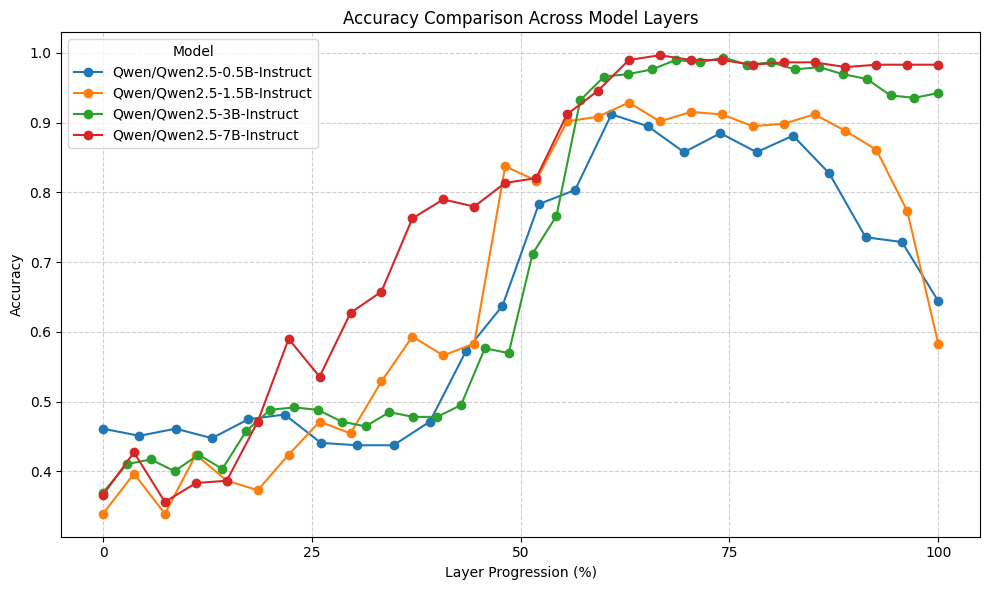

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# List of model identifiers.
model_names = [
    "Qwen/Qwen2.5-0.5B-Instruct",
    # "Qwen/Qwen2.5-1.5B-Instruct",
    # "Qwen/Qwen2.5-3B-Instruct",
    # "Qwen/Qwen2.5-7B-Instruct"
]
def LoadDataset(filename):
    with open(filename, 'r+') as f:
        read_dict = f.read()
    return json.loads(read_dict)

# Initialize a list to store accuracy results.
acc_results = []
for model in model_names:
    if os.path.exists(model.replace("/","_") + "_final76.json"):
        acc = LoadDataset(model.replace("/","_") + "_final.json")["Acc"]
        acc_results.append(acc)
    else:
        acc, f1, auc = run_model(model, quant=8, dataset="HallData")
        acc_results.append(acc)


# plot_accuracy_curves(acc_results, model_names, target_accuracy=0.80, save_path="accuracy_layers.pdf", dataset_name="HallData")
# # Create a larger figure for better readability.
plt.figure(figsize=(10, 6))

# Iterate through each model's results.
for i, acc in enumerate(acc_results):
    num_layers = len(acc)
    # Create x-values that scale linearly from 0 to 100.
    x_values = np.linspace(0, num_layers, num=num_layers)
    plt.plot(x_values, acc, marker='o', linestyle='-', label=model_names[i])

# Customize the plot.
plt.xlabel("Layer Progression (%)")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Model Layers")
plt.xticks([0, 25, 50, 75, 100])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(title="Model")
plt.tight_layout()

# Display the plot.
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# List of model identifiers.
model_names = [
    "Qwen/Qwen2.5-0.5B-Instruct",
    "Qwen/Qwen2.5-1.5B-Instruct",
    "Qwen/Qwen2.5-3B-Instruct",
    "Qwen/Qwen2.5-7B-Instruct"
]
def LoadDataset(filename):
    with open(filename, 'r+') as f:
        read_dict = f.read()
    return json.loads(read_dict)

# Initialize a list to store accuracy results.
acc_results = []
for model in model_names:
    if os.path.exists(model.replace("/","_") + "_final76.json"):
        acc = LoadDataset(model.replace("/","_") + "_final.json")["Acc"]
        acc_results.append(acc)
    else:
        acc, f1, auc = run_model(model, quant=8, dataset="HallDataV2")
        acc_results.append(acc)


plt.figure(figsize=(10, 6))

# Iterate through each model's results.
for i, acc in enumerate(acc_results):
    num_layers = len(acc)
    # Create x-values that scale linearly from 0 to 100.
    x_values = np.linspace(0, 100, num=num_layers)
    plt.plot(x_values, acc, marker='o', linestyle='-', label=model_names[i])

# Customize the plot.
plt.xlabel("Layer Progression (%)")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Model Layers")
plt.xticks([0, 25, 50, 75, 100])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(title="Model")
plt.tight_layout()

# Display the plot.
plt.show()

README.md:   0%|          | 0.00/504 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)-00000-of-00001-6214bf2299f14220.parquet:   0%|          | 0.00/104k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1634 [00:00<?, ? examples/s]

KeyError: "Column question not in the dataset. Current columns in the dataset: ['prompt', 'answer', 'label']"

In [ ]:
plt.figure(figsize=(10, 6))

# Iterate through each model's results.
for i, acc in enumerate(acc_results):
    num_layers = len(acc)
    # Create x-values that scale linearly from 0 to 100.
    x_values = np.linspace(0, 100, num=num_layers)
    plt.plot(x_values, acc, marker='o', linestyle='-', label=model_names[i])

# Customize the plot.
plt.xlabel("Layer Progression (%)")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Model Layers")
plt.xticks([0, 25, 50, 75, 100])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(title="Model")
plt.tight_layout()

# Display the plot.
plt.show()

In [ ]:
from nnsight import LanguageModel

def get_layers_and_norm(model):
    """Detect and return the transformer layers and norm based on model architecture."""
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        print("Detected LLaMA-style model.")
        return model.model.layers, model.model.norm
    elif hasattr(model, "transformer") and hasattr(model.transformer, "h"):
        print("Detected GPT-style model.")
        return model.transformer.h, model.transformer.ln_f
    else:
        raise ValueError("Unsupported model architecture: can't find transformer layers or norm.")


def compute_logit_lens(prompt, model):
    print(f"Computing logit lens for prompt: '{prompt}'")
    probs_layers = []

    layers, final_norm = get_layers_and_norm(model)

    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            for layer in layers:
                layer_out = model.lm_head(final_norm(layer.output[0]))
                probs = torch.nn.functional.softmax(layer_out, dim=-1).save()
                probs_layers.append(probs)

            input_ids = invoker.inputs[0][0]["input_ids"][0]

    probs = torch.cat([p.value.unsqueeze(0) for p in probs_layers], dim=0)
    max_probs, tokens = probs.max(dim=-1)

    last_n = 10
    input_words = [model.tokenizer.decode(t) for t in input_ids[-last_n:]]
    words = [
        [model.tokenizer.decode(t.cpu()) for t in layer_tokens[-last_n:]]
        for layer_tokens in tokens
    ]

    max_probs = max_probs[:, -last_n:]
    return max_probs.detach().cpu().numpy(), words, input_words


def autoregressive_logit_lens_animation(prompt, model, temperature=1.0, max_steps=5):
    frames = []
    current_prompt = prompt
    print(f"Starting generation with initial prompt: '{prompt}'")

    for step in range(max_steps):
        print(f"Generating step {step + 1}/{max_steps}...")
        max_probs, layer_words, input_words = compute_logit_lens(current_prompt, model)

        frames.append({
            'step': step,
            'prompt': current_prompt,
            'max_probs': max_probs,
            'layer_words': layer_words,
            'input_words': input_words,
        })
        messages = [
                {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ]
        input_text_new = model.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        inputs = model.tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
            last_logits = outputs.logits[0, -1]

        probs = torch.nn.functional.softmax(last_logits / temperature, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1)
        next_token = model.tokenizer.decode(next_token_id)

        if next_token.strip() == "":
            next_token = " " + next_token

        print(f"Generated token: '{next_token}'")
        for i, tokens_row in enumerate(layer_words):
            import re
            token_str = " | ".join(tokens_row[-max_steps:]).replace("\n", " ")
            token_str = re.sub(r"[-_]+", " ", token_str)
            print(f"[LAYER {i}]: {token_str}\n")
        # print({"step": step, "prompt": current_prompt, "layer_words": layer_words, "input_words": input_words})
        current_prompt += next_token

    print(f"Final text: '{current_prompt}'")
    return frames